## This project is about translate english to vietnamese using seq2seq model

In [2]:
%config IPCompleter.use_jedi = False

In [3]:
from pyvi import ViTokenizer, ViPosTagger, ViUtils
import pyvi
import re
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
%run contractions.ipynb
%run ../Utils.ipynb

## After EDA, i see the english data dont match with the vietnamese data, so i have modified the data then you can download 2 file "modified_vi.txt" and "modified_en.txt" and use it 

In [3]:
vi_df = pd.read_csv('modified_vi.txt', delimiter = "\t")

In [4]:
eng_df = pd.read_csv('modified_en.txt', delimiter = "\t")

## You can use origin data from this [github link](https://github.com/stefan-it/nmt-en-vi)
## Read file, uncomment the code below and run 

In [5]:
# df.Col[469:-1] = df.Col[470:] 
# df.Col[8694:-1] = df.Col[8695:]
# df.Col[9760:-1] = df.Col[9761:] 
# df.Col[10704:-1] = df.Col[10705:] 
# df.Col[21734:-1] = df.Col[21735:] 
# df.Col[26403:-1] = df.Col[26404:] 
# df.Col[29488:-1] = df.Col[29489:] 
# df.Col[38593:-1] = df.Col[38594:] 
# df.Col[41009:-1] = df.Col[41010:]
# df.Col[48816:-1] = df.Col[48817:]
# df.Col[50884:-1] = df.Col[50885:]
# df.Col[51575:-1] = df.Col[51576:]
# df.Col[54146:-1] = df.Col[54147:]
# df.Col[56284:-1] = df.Col[56285:]
# df.Col[57126:-1] = df.Col[57127:]
# df.Col[57731:-1] = df.Col[57732:]
# df.Col[58314:-1] = df.Col[58315:]
# df.Col[66243:-1] = df.Col[66244:]
# df.Col[68737:-1] = df.Col[68738:]
# df.Col[73559:-1] = df.Col[73560:]
# df.Col[76876:-1] = df.Col[76877:]
# df.Col[77167:-1] = df.Col[77168:]
# df.Col[79647:-1] = df.Col[79648:]
# df.Col[87589:-1] = df.Col[87590:]
# df.Col[88613:-1] = df.Col[88614:]
# df.Col[89906:-1] = df.Col[89907:]
# df.Col[94034:-1] = df.Col[94035:]
# df.Col[104098:-1] = df.Col[104099:]
# df.Col[104649:-1] = df.Col[104650:]
# df.Col[106977:-1] = df.Col[106978:]
# df.Col[112793:-1] = df.Col[112794:]
# df.Col[115151:-1] = df.Col[115152:]
# eng_df.Col[121582:-1] = eng_df.Col[121583:]
# df.Col[123042:-1] = df.Col[123043:]
# df.Col[124883:-1] = df.Col[124884:]
# df.Col[125175:-1] = df.Col[125176:]
# df.Col[127990:-1] = df.Col[127991:]
# df.Col[130085:-1] = df.Col[130086:]
# df.Col[130733:-1] = df.Col[130734:]

In [6]:
# lines = new_en_df.values
# with open('modified_en.txt', 'w', encoding='utf-8') as f:
#     f.write('\n'.join(lines))

## The dataset is about 130k rows, but i only use 50k rows for time saving

In [7]:
eng_sents = eng_df.Col.values[0:50000]
vi_sents = vi_df.Col.values[0:50000]

# Preprocessing

In [8]:
def expand_contractions(s, contractions_dict=CONTRACTION_MAP):
    c_re = re.compile('(%s)' % '|'.join(CONTRACTION_MAP.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return c_re.sub(replace, s)

def eng_preprocessing(text):
    text = text.lower()
    #remove html tag
    text = re.sub('\s\B&apos;', "'", text)
    text = re.sub('\s\B&quot;', '', text)
    #contractions
    text = expand_contractions(text)
    #remove special character
    text = re.sub("[^a-zA-z0-9\s]", ' ',text)
    #add sos and eos token
    text = " ".join(['SOS', text, 'EOS'])
    return text
eng_sents = list(map(eng_preprocessing, eng_sents))


In [9]:
def vi_preprocessing(text):
    text = text.lower()
    text = re.sub('\s\B&apos;', "'", text)
    text = re.sub('\s\B&quot;', '', text)
    text = re.sub(r"[!@#$%~&-/?><.,;:{}+_`|^=]", ' ', text)
    text = " ".join(['SOS', text, 'EOS'])
    return text
vi_sents = list(map(vi_preprocessing, vi_sents))


In [10]:
eng_sents[0:5]

['SOS rachel pike   the science behind a climate headline EOS',
 'SOS in 4 minutes   atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change   with her team    one of thousands who contributed    taking a risky flight over the rainforest in pursuit of data on a key molecule   EOS',
 'SOS i would like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper   EOS',
 'SOS headlines that look like this when they have to do with climate change   and headlines that look like this when they have to do with air quality or smog   EOS',
 'SOS they are both two branches of the same field of atmospheric science   EOS']

In [11]:
vi_sents[5:10]

['SOS các tiêu đề gần đây trông như thế này khi ban điều hành biến đổi khí hậu liên chính phủ   gọi tắt là ipcc đưa ra bài nghiên cứu của họ về hệ thống khí quyển EOS',
 'SOS nghiên cứu được viết bởi 620 nhà khoa học từ 40 quốc gia khác nhau EOS',
 'SOS họ viết gần 1000 trang về chủ đề này EOS',
 'SOS và tất cả các trang đều được xem xét bởi 400 khoa học gia và nhà phê bình khác từ 113 quốc gia EOS',
 'SOS đó là cả một cộng đồng lớn   lớn đến nỗi trên thực tế cuộc tụ hội hằng năm của chúng tôi là hội nghị khoa học   91  tự nhiên   93  lớn nhất thế giới EOS']

## I use package pyvi for tokenize vietnamese text 

In [12]:
text = vi_sents[6]
for ind in range(len(ViTokenizer.tokenize(text).split())):
    print(ViPosTagger.postagging(ViTokenizer.tokenize(text))[0][ind], ViPosTagger.postagging(ViTokenizer.tokenize(text))[1][ind])


SOS Ny
nghiên_cứu V
được V
viết V
bởi E
620 M
nhà N
khoa_học N
từ E
40 M
quốc_gia N
khác A
nhau N
EOS Np


In [13]:
vi_tok = [ViTokenizer.tokenize(text).split() for text in vi_sents]
eng_tok = [text.split() for text in eng_sents]

## Create word2index Dictionary for encoding sentence

In [14]:
import gensim
from gensim import corpora
eng_vocal = corpora.Dictionary(eng_tok)
vi_vocal = corpora.Dictionary(vi_tok)

## The pad token has the value 0

In [15]:
special_tokens = {'PAD': 0}
eng_vocal.patch_with_special_tokens(special_tokens)
vi_vocal.patch_with_special_tokens(special_tokens)

In [16]:
len(eng_vocal)

26990

In [17]:
len(vi_vocal)

20653

In [18]:
len_vi_sent = [len(text) for text in vi_tok]
len_eng_sent = [len(text) for text in eng_tok]

In [19]:
count = 0
for sent in len_vi_sent:
    if sent >= 40:
        count = count+1
print(count)

3989


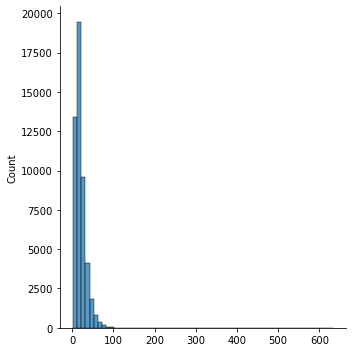

In [20]:
sns.displot(x=len_vi_sent, binwidth=10)

## Encode sentence

In [21]:
def eng_encode_sent(sent):
    sent = [eng_vocal.token2id[word] for word in sent if word in eng_vocal.token2id.keys()]
    return sent
def vi_encode_sent(sent):
    sent = [vi_vocal.token2id[word] for word in sent if word in vi_vocal.token2id.keys()]
    return sent
eng_encoded = list(map(eng_encode_sent, eng_tok))
vi_encoded = list(map(vi_encode_sent, vi_tok))

## Padding encoded sentence

In [22]:
def pad_features(encoded_sent, seq_length):
    features = np.zeros((len(encoded_sent), seq_length), dtype = int)
    
    for i, review in enumerate(encoded_sent):
        review_len = len(review)
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = review+zeroes
        elif review_len > seq_length:
            new = review[0:seq_length]
        features[i,:] = np.array(new)  
    return features

eng_encoded = pad_features(eng_encoded, 40)
vi_encoded = pad_features(vi_encoded, 40)

X = eng_encoded
y = vi_encoded

In [23]:
eng_encoded[0]

array([    1,     7,     6,     9,     8,     3,     2,     4,     5,
       26989,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

# Train test split and batch loader

In [24]:
rate = 0.1/0.9
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=rate, random_state=1)

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [26]:
batch_size = 10
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [27]:
# for x, y in train_loader:
#     print(x.size())
#     break

## Create encoder model

### each word of source sentence will be the input of lstm cell, then the lstm cell outputs hidden cell and its output. 
### The last hidden cell is the input of encoder

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim, p_drop, n_layers):
        super().__init__()
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.p_drop = p_drop
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=p_drop)
        self.dropout = nn.Dropout(p_drop)
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))

        
        return hidden
    
    def forward(self, x, h):
        #x: [batch_size, seq_len]
        out = self.embedding(x)
        #out: [batch_size, seq_len, embedding_dim]
        out = self.dropout(out)
        out, h = self.lstm(out, h)
        return h


In [29]:
ENCODER_INPUT_SIZE = len(eng_vocal)
ENCODER_EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
P_DROP = 0.5

encoder = Encoder(ENCODER_INPUT_SIZE, ENCODER_EMBEDDING_DIM, HIDDEN_DIM,P_DROP, N_LAYERS)
encoder = encoder.to(device)

In [30]:

# for x, y in train_loader:
#     if torch.cuda.is_available():
#         x = x.cuda()
#         y = y.cuda()
#     h = encoder.init_hidden(batch_size)
#     out, h = encoder(x, h)
#     print(h[0].size())
#     break

## Create Decoder model

### the len of input in each lstm cell of decoder is 1, because we fetch only 1 word to predict the next word
### i use teacher forcing to make convergence faster

In [31]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, p_drop, n_layers):
        super().__init__()
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.p_drop = p_drop
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.dropout = nn.Dropout(p=p_drop)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout = p_drop)
        self.fc1 = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, h):
        out = x.unsqueeze(1)
        #out: [batch_size = 1, seq_len]
        out = self.embedding(out)
        #out: [1, seq_len, embedding_dim]
        out = self.dropout(out)
        out, h = self.lstm(out, h)
        #out: [1, seq_len, hidden_dim]
        out = out.reshape(-1, self.hidden_dim)
        #out: [seq_len, hidden_dim]
        out = self.fc1(out)
        #out: [seq_len, output_size]
        return out, h
    


In [32]:
DECODER_OUTPUT_SIZE = len(vi_vocal)
DECODER_EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
P_DROP = 0.5

decoder = Decoder(DECODER_OUTPUT_SIZE, DECODER_EMBEDDING_DIM, HIDDEN_DIM,P_DROP, N_LAYERS)
decoder = decoder.to(device)

In [33]:
# for x, y in train_loader:
#     if torch.cuda.is_available():
#         x = x.cuda()
#         y = y.cuda()
#     input =y[:,1]
#     out1 = decoder(input, h)
#     print(out1.size())
# #     print(input[:,0].size())
#     break

In [34]:
import random
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder= encoder
        self.decoder = decoder
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        trg_len = trg.size(1)
        trg_batch = trg.size(0)
        #tensor to store outputs
        outputs = torch.zeros(trg_len, trg_batch, DECODER_OUTPUT_SIZE)
        outputs = outputs.to(device)
        hidden = self.encoder.init_hidden(trg_batch)
        h = self.encoder(src, hidden)
        #We use the first word of target data SOS to fetch into decoder
        input = trg[:, 0]
        
        for i in range(1, trg_len):
            output, h = self.decoder(input, h)
            outputs[i] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[:,i] if teacher_force else top1
        return outputs

In [35]:
seq_model = Seq2Seq(encoder, decoder)
seq_model = seq_model.to(device)
seq_model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(26990, 256)
    (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(20653, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc1): Linear(in_features=512, out_features=20653, bias=True)
  )
)

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq_model):,} trainable parameters')

The model has 30,148,013 trainable parameters


In [37]:
len(train_loader)

4000

# Train model

In [1]:
lr = 0.001
optimizer = torch.optim.Adam(seq_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=0)
clip = 5
epouchs = 3

train_loss_arr = []

seq_model.train()
#     model.eval()
for epouch in range(epouchs):
    epoch_loss = 0
    count = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        batch = y.size(0)
        output = seq_model(x, y)

        output_dim = output.size(2)
        output = output[1:].reshape(-1, output_dim)

        y = y.reshape(-1, batch)
        trg = y[1:].reshape(-1)

        loss = criterion(output, trg.long().to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(seq_model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
#             if count % 100 ==0:
        print(count)
        count = count + 1
    print(f'Epouch: {epouch + 1}, Train Loss: {epoch_loss / len(train_loader)}')
    train_loss_arr.append(epoch_loss / len(train_loader))


## Predict unseen sentence

In [4]:
text = "beautiful girl"
def predict(text, max_length):
    text = " ".join(['SOS', text, 'EOS'])
    text = [eng1_encode_sent(text)]
    text = pad_features(text, 40)
    text = torch.from_numpy(np.array(text))

    if torch.cuda.is_available():
        text = text.cuda()
    outputs = [vi_vocal.token2id['SOS']]
    h = seq_model.encoder.init_hidden(1)
    seq_model.eval()
    with torch.no_grad():
        h = seq_model.encoder(text, h)
     
    for i in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).cuda()
        with torch.no_grad():
            output, h = seq_model.decoder(previous_word, h)
#             return output
            best_guess = output.argmax(1).item()
        outputs.append(best_guess)

        Model predicts it's the end of the sentence
        if output.argmax(1).item() == vi_vocal.token2id['EOS']:
            break
    
    return outputs
predict(text,2)

[1, 1571, 2730]

In [39]:
def eng1_encode_sent(sent):
    new = [eng_vocal.token2id[word] for word in sent.split() if word in eng_vocal.token2id.keys()]
    return new

eng1_encode_sent("beautiful girl")

[1571, 2730]